Empirical correlation of returns: 0.796


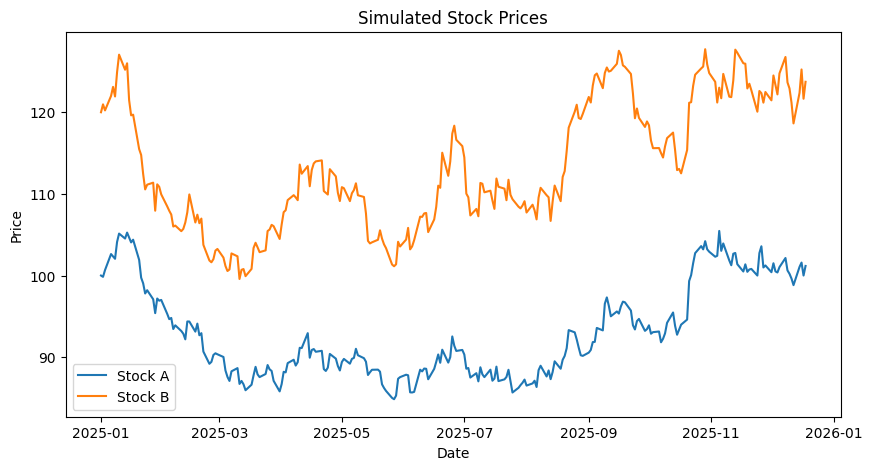

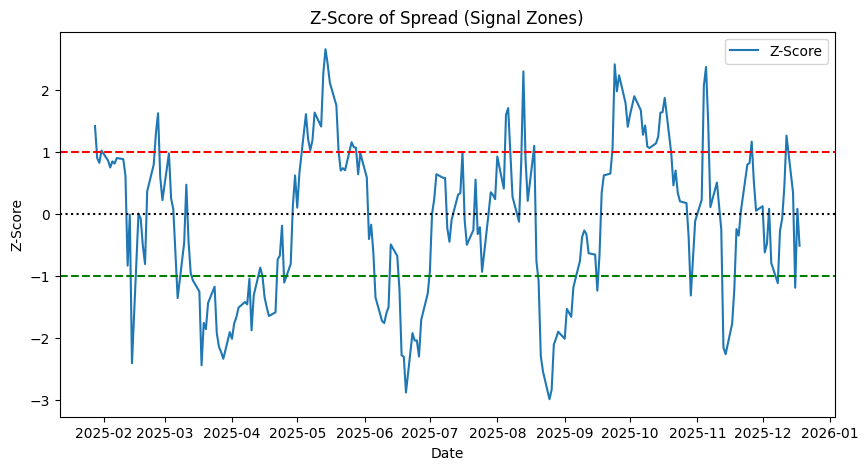

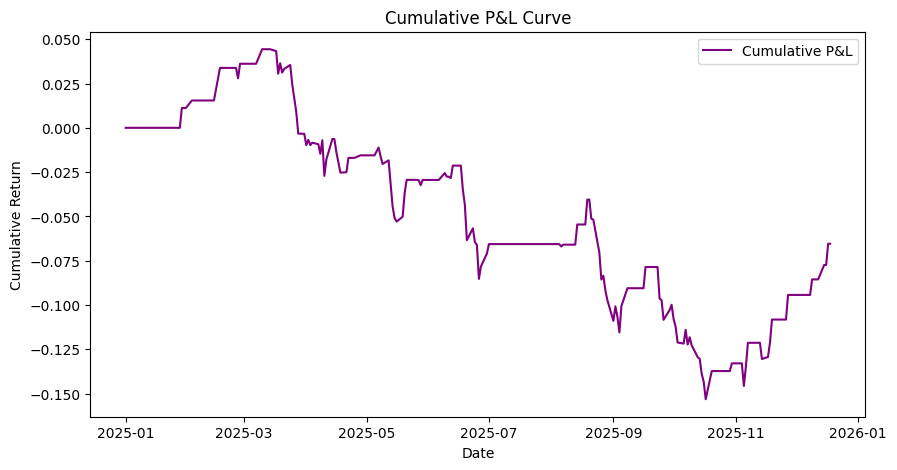


=== Performance Metrics ===
          Metric   Value
    Total Return  -6.54%
    Sharpe Ratio   -0.63
Max Drawdown (%) -18.92%


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Synthetic Price Parameters ---

S_A0, S_B0 = 100, 120
mu_A, mu_B = 0.05, 0.04
sigma_A, sigma_B = 0.2, 0.25
rho = 0.8
T = 1
steps = 252
dt = T / steps

np.random.seed(42)

# --- Correlated Brownian motions ---
Z_A = np.random.standard_normal(steps)
Z_B = np.random.standard_normal(steps)
Z_B_corr = rho * Z_A + np.sqrt(1 - rho ** 2) * Z_B

# --- Price arrays ---
S_A = np.zeros(steps)
S_B = np.zeros(steps)
S_A[0], S_B[0] = S_A0, S_B0

for t in range(1, steps):
    S_A[t] = S_A[t-1] * np.exp((mu_A - 0.5 * sigma_A**2) * dt + sigma_A * np.sqrt(dt) * Z_A[t])
    S_B[t] = S_B[t-1] * np.exp((mu_B - 0.5 * sigma_B**2) * dt + sigma_B * np.sqrt(dt) * Z_B_corr[t])

dates = pd.date_range('2025-01-01', periods = steps, freq='B')
data = pd.DataFrame({'A': S_A, 'B': S_B}, index=dates)

# --- Verify correlation of returns ---

returns = data.pct_change().dropna()
corr_check = returns['A'].corr(returns['B'])
print(f"Empirical correlation of returns: {corr_check:.3f}")

data['Spread'] = data['A'] - data['B']
window = 20
data['Spread_Mean'] = data['Spread'].rolling(window).mean()
data['Spread_Std'] = data['Spread'].rolling(window).std()
data['Zscore'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_Std']

data['Position'] = 0  # Default: Hold
data.loc[data['Zscore'] < -1, 'Position'] = 1   # Long A, short B
data.loc[data['Zscore'] > 1, 'Position'] = -1   # Short A, long B
data.loc[data['Zscore'].abs() < 0.25, 'Position'] = 0  # Close
data['Position'] = data['Position'].shift(1)

data['Return_A'] = data['A'].pct_change()
data['Return_B'] = data['B'].pct_change()
data['Strategy_Return'] = data['Position'] * (data['Return_A'] - data['Return_B'])
data['Cumulative_PnL'] = (1 + data['Strategy_Return'].fillna(0)).cumprod() - 1

# --- Data Visualisation ---

plt.figure(figsize=(10, 5))
plt.plot(data['A'], label='Stock A')
plt.plot(data['B'], label='Stock B')
plt.title('Simulated Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data['Zscore'], label='Z-Score')
plt.axhline(1, color='r', linestyle='--')
plt.axhline(-1, color='g', linestyle='--')
plt.axhline(0, color='k', linestyle=':')
plt.title('Z-Score of Spread (Signal Zones)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Cumulative P&L Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# --- Performance Metrics ---

def max_drawdown(series):
    roll_max = series.cummax()
    drawdown = (series - roll_max) / roll_max
    return drawdown.min()

total_return = data['Cumulative_PnL'].iloc[-1]
sharpe_ratio = (data['Strategy_Return'].mean() / data['Strategy_Return'].std()) * np.sqrt(252)
mdd = max_drawdown(data['Cumulative_PnL'] + 1) * 100

metrics = pd.DataFrame({
    'Metric': ['Total Return', 'Sharpe Ratio', 'Max Drawdown (%)'],
    'Value': [f"{total_return*100:.2f}%", f"{sharpe_ratio:.2f}", f"{mdd:.2f}%"]
})

print("\n=== Performance Metrics ===")
print(metrics.to_string(index=False))
